In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('../data-local/online_retail_cleaned_2009-2011.csv')
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"]).dt.normalize()
df = df.dropna(subset=['CustomerID'])
df['CustomerID'] = df['CustomerID'].astype(int).astype(str)
print(df.shape)
df.head(3)

(824364, 10)


InvoiceNo StockCode                          Description  Quantity  \
0    489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1    489434    79323P                   PINK CHERRY LIGHTS        12   
2    489434    79323W                  WHITE CHERRY LIGHTS        12   

  InvoiceDate  UnitPrice CustomerID         Country  IsCancelled  TotalPrice  
0  2009-12-01       6.95      13085  United Kingdom        False        83.4  
1  2009-12-01       6.75      13085  United Kingdom        False        81.0  
2  2009-12-01       6.75      13085  United Kingdom        False        81.0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 824364 entries, 0 to 1062988
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    824364 non-null  object        
 1   StockCode    824364 non-null  object        
 2   Description  824364 non-null  object        
 3   Quantity     824364 non-null  int64         
 4   InvoiceDate  824364 non-null  datetime64[ns]
 5   UnitPrice    824364 non-null  float64       
 6   CustomerID   824364 non-null  object        
 7   Country      824364 non-null  object        
 8   IsCancelled  824364 non-null  bool          
 9   TotalPrice   824364 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 63.7+ MB


In [5]:
df = df[~df['Description'].isin(['Manual','Discount','This is a test product.'])]
df.shape

(823059, 10)

In [6]:
df_diario = df.groupby(['CustomerID','InvoiceDate','Country']).agg(
            Invoices=('InvoiceNo', lambda x: x[~x.str.startswith('C')].nunique()),
            Invoices_canceled=('InvoiceNo', lambda x: x[x.str.startswith('C')].nunique()),
            Unique_products_buy=('StockCode', lambda x: x[df.loc[x.index, 'Quantity'] > 0].nunique()),
            Unique_products_return=('StockCode', lambda x: x[df.loc[x.index, 'Quantity'] < 0].nunique()),
            Items_buy=('Quantity', lambda x: x[x > 0].sum()),
            Items_return=('Quantity', lambda x: x[x < 0].sum()),
            Items_net=('Quantity','sum'),
            Value_buy=('TotalPrice', lambda x: x[x > 0].sum()),
            Value_return=('TotalPrice', lambda x: x[x < 0].sum()),
            Total_value=('TotalPrice', 'sum'),
            ).reset_index()
df_diario.head(3)

CustomerID InvoiceDate         Country  Invoices  Invoices_canceled  \
0      12346  2010-01-26  United Kingdom         0                  1   
1      12346  2010-03-02  United Kingdom         1                  0   
2      12346  2010-06-28  United Kingdom         1                  0   

   Unique_products_buy  Unique_products_return  Items_buy  Items_return  \
0                    0                       1          0            -1   
1                    5                       0          5             0   
2                   19                       0         19             0   

   Items_net  Value_buy  Value_return  Total_value  
0         -1       0.00        -103.5      -103.50  
1          5      27.05           0.0        27.05  
2         19     142.31           0.0       142.31

In [7]:
df_final = df_diario[(df_diario['Items_net'] != 0)
                    & (df_diario['Total_value'] != 0)
                    ]
df_final.shape

(38039, 13)

In [8]:
# Ventasas churn
meses_obs = 3
meses_churn = 3
obs_ini = df_final['InvoiceDate'].min() # 2010-12-01

window = []
window_id = 1

while True:
    obs_end = obs_ini + pd.DateOffset(months=meses_obs) - pd.DateOffset(days=1)
    churn_ini = obs_end + pd.DateOffset(days=1)
    churn_end = churn_ini + pd.DateOffset(months=meses_churn) - pd.DateOffset(days=1)

    if churn_end > df_final['InvoiceDate'].max():
        break

    df_obs = df_final[(df_final['InvoiceDate'] >= obs_ini) & (df_final['InvoiceDate'] <= obs_end)]
    df_churn = df_final[(df_final['InvoiceDate'] >= churn_ini) & (df_final['InvoiceDate'] <= churn_end) & (df_final['Items_net'] > 0)]

    customers_obs = df_obs['CustomerID'].dropna().unique()
    customer_churn = df_churn['CustomerID'].dropna().unique()

    for customer in customers_obs:

        df_cliente = df_obs[df_obs['CustomerID'] == customer].copy()
        # df_cliente['quantity_buy'] = np.where(df_cliente['Quantity'] > 0, df_cliente['Quantity'], 0)
        # df_cliente['quantity_return'] = np.where(df_cliente['Quantity'] < 0, -df_cliente['Quantity'],0)

        # Compras
        total_products_buys = df_cliente['Items_buy'].sum()
        value_buys = df_cliente['Value_buy'].sum()
        invoices_buy = df_cliente['Invoices'].sum()
        avg_invoice_buy = value_buys / invoices_buy if invoices_buy > 0 else 0
        # promedio_monto_producto = total_gasto / total_productos_comprados if total_productos_comprados > 0 else 0
        products_unique_buys = df_cliente['Unique_products_buy'].nunique()

        # Devoluciones
        total_products_return = df_cliente['Items_return'].nunique()
        value_return = df_cliente['Value_return'].sum()
        invoices_return = df_cliente['Invoices_canceled'].sum()
        avg_invoice_return = value_return / invoices_return if invoices_return > 0 else 0
        products_unique_return = df_cliente['Unique_products_return'].nunique()

        # mes frecuente
        mes_frecuente = df_cliente['InvoiceDate'].dt.month.mode()

        # Total
        total_products = df_cliente['Items_net'].sum()
        total_value_obs = df_cliente['Total_value'].sum()
        total_value_std = df_cliente['Total_value'].std(ddof=0)

        # Variables of time
        customer_longevity = (df_churn['InvoiceDate'].max() - df_cliente['InvoiceDate'].min()).days
        recency_days = (df_obs['InvoiceDate'].max() - df_cliente['InvoiceDate'].max()).days
        fechas = df_cliente['InvoiceDate'].drop_duplicates().sort_values()
        if len(fechas) > 1:
            diffs = fechas.diff().dropna()
            promedio_dias_entre_compras = diffs.mean().days
        else:
            promedio_dias_entre_compras = (df_obs['InvoiceDate'].max() - df_cliente['InvoiceDate'].max()).days

        # Ratio
        return_rate = total_products_return / total_products_buys if total_products_buys > 0 else np.nan
        return_value_rate = value_return / value_buys if value_buys > 0 else np.nan
        
        # Value in window churn
        value_churn = df_churn[df_churn['CustomerID'] == customer]['Total_value'].sum()

        # Churn
        churn = 1 if (customer not in customer_churn or value_churn <= 0.2 * total_value_obs) else 0

        # Filtrar que la ventana no tenga solo devoluciones

        if total_products_buys == 0 and total_products_return > 0:
            continue

        window.append({
            'CustomerID': customer,
            'window_id': window_id,
            'total_products': total_products,
            'total_products_buys': total_products_buys,
            'value_buys': value_buys,
            'products_unique_buys': products_unique_buys,
            'avg_invoice_buy': avg_invoice_buy,
            'invoices_buy': invoices_buy,
            'total_products_return': total_products_return,
            'value_return': value_return,
            'products_unique_return': products_unique_return,
            'avg_invoice_return': avg_invoice_return,
            'invoices_return': invoices_return,
            'total_value_obs':total_value_obs,
            'total_value_std': total_value_std,
            'return_rate': return_rate,
            'return_value_rate': return_value_rate,
            'recency_days': recency_days,
            'customer_longevity': customer_longevity,
            'days_between_purchases': promedio_dias_entre_compras,
            'month_frecuency': mes_frecuente.iloc[0] if not mes_frecuente.empty else np.nan,
            'churn': churn
        })

    obs_ini = obs_ini + pd.DateOffset(months=meses_obs)
    window_id += 1

df_ventanas = pd.DataFrame(window)
# df_ventanas = pd.get_dummies(df_ventanas, columns=['mes_frecuente'], prefix='mes', dtype=int)
# df_ventanas['ventana_id'].value_counts()
df_ventanas


CustomerID  window_id  total_products  total_products_buys  value_buys  \
0          12358          1             309                  309     1429.83   
1          12359          1             397                  397      760.69   
2          12360          1             100                  100      118.00   
3          12361          1              45                   45      109.20   
4          12362          1               1                    1      130.00   
...          ...        ...             ...                  ...         ...   
14186      18265          7             224                  224      488.55   
14187      18272          7             677                  677     1125.91   
14188      18281          7              54                   54       80.82   
14189      18282          7              70                   75      100.21   
14190      18283          7             311                  311      450.72   

       products_unique_buys  avg_invoice_buy  invoices_buy  \
0                         1         1429.830             1   
1                         1          760.690             1   
2                         1          118.000             1   
3                         1          109.200             1   
4                         1          130.000             1   
...                     ...              ...           ...   
14186                     1          488.550             1   
14187                     2          562.955             2   
14188                     1           80.820             1   
14189                     2          100.210             1   
14190                     3          112.680             4   

       total_products_return  value_return  ...  invoices_return  \
0                          1          0.00  ...                0   
1                          1          0.00  ...                0   
2                          1          0.00  ...                0   
3                          1          0.00  ...                0   
4                          1          0.00  ...                0   
...                      ...           ...  ...              ...   
14186                      1          0.00  ...                0   
14187                      1          0.00  ...                0   
14188                      1          0.00  ...                0   
14189                      2         -1.45  ...                1   
14190                      1          0.00  ...                0   

       total_value_obs  total_value_std  return_rate  return_value_rate  \
0              1429.83         0.000000     0.003236            0.00000   
1               760.69         0.000000     0.002519            0.00000   
2               118.00         0.000000     0.010000            0.00000   
3               109.20         0.000000     0.022222            0.00000   
4               130.00         0.000000     1.000000            0.00000   
...                ...              ...          ...                ...   
14186           488.55         0.000000     0.004464            0.00000   
14187          1125.91       190.705000     0.001477            0.00000   
14188            80.82         0.000000     0.018519            0.00000   
14189            98.76        50.830000     0.026667           -0.01447   
14190           450.72        41.164539     0.003215            0.00000   

       recency_days  customer_longevity  days_between_purchases  \
0                82                 173                      82   
1                85                 176                      85   
2                 6                  97                       6   
3                33                 124                      33   
4                89                 180                      89   
...             ...                 ...                     ...   
14186            58                 149                      58   
14187            13                 141       

In [9]:
df_ventanas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14191 entries, 0 to 14190
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              14191 non-null  object 
 1   window_id               14191 non-null  int64  
 2   total_products          14191 non-null  int64  
 3   total_products_buys     14191 non-null  int64  
 4   value_buys              14191 non-null  float64
 5   products_unique_buys    14191 non-null  int64  
 6   avg_invoice_buy         14191 non-null  float64
 7   invoices_buy            14191 non-null  int64  
 8   total_products_return   14191 non-null  int64  
 9   value_return            14191 non-null  float64
 10  products_unique_return  14191 non-null  int64  
 11  avg_invoice_return      14191 non-null  float64
 12  invoices_return         14191 non-null  int64  
 13  total_value_obs         14191 non-null  float64
 14  total_value_std         14191 non-null

In [10]:
df_ventanas.columns

Index(['CustomerID', 'window_id', 'total_products', 'total_products_buys',
       'value_buys', 'products_unique_buys', 'avg_invoice_buy', 'invoices_buy',
       'total_products_return', 'value_return', 'products_unique_return',
       'avg_invoice_return', 'invoices_return', 'total_value_obs',
       'total_value_std', 'return_rate', 'return_value_rate', 'recency_days',
       'customer_longevity', 'days_between_purchases', 'month_frecuency',
       'churn'],
      dtype='object')

In [20]:
def cap_outliers_iqr(df, cols, group_col='window_id'):
    df_out = df.copy()
    
    for col in cols:
        # Asegurarse que la columna sea float para evitar errores al asignar Q1/Q3
        if not pd.api.types.is_float_dtype(df_out[col]):
            df_out[col] = df_out[col].astype(float)

        for window, g in df.groupby(group_col):
            Q1 = g[col].quantile(0.25)
            Q3 = g[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR

            # Reemplazar outliers menores al límite inferior
            mask_lower = (df_out[group_col] == window) & (df_out[col] < lower)
            df_out.loc[mask_lower, col] = Q1

            # Reemplazar outliers mayores al límite superior
            mask_upper = (df_out[group_col] == window) & (df_out[col] > upper)
            df_out.loc[mask_upper, col] = Q3

    return df_out

df_ventanas_f = cap_outliers_iqr(df_ventanas, df_ventanas.drop(columns=['CustomerID', 'window_id', 'churn']).columns.tolist())
df_ventanas_f

CustomerID  window_id  total_products  total_products_buys  value_buys  \
0          12358          1           309.0                309.0     1429.83   
1          12359          1           397.0                397.0      760.69   
2          12360          1           100.0                100.0      118.00   
3          12361          1            45.0                 45.0      109.20   
4          12362          1             1.0                  1.0      130.00   
...          ...        ...             ...                  ...         ...   
14186      18265          7           224.0                224.0      488.55   
14187      18272          7           677.0                677.0     1125.91   
14188      18281          7            54.0                 54.0       80.82   
14189      18282          7            70.0                 75.0      100.21   
14190      18283          7           311.0                311.0      450.72   

       products_unique_buys  avg_invoice_buy  invoices_buy  \
0                       1.0        438.01875           1.0   
1                       1.0        760.69000           1.0   
2                       1.0        118.00000           1.0   
3                       1.0        109.20000           1.0   
4                       1.0        130.00000           1.0   
...                     ...              ...           ...   
14186                   1.0        488.55000           1.0   
14187                   2.0        562.95500           2.0   
14188                   1.0         80.82000           1.0   
14189                   2.0        100.21000           1.0   
14190                   3.0        112.68000           2.0   

       total_products_return  value_return  ...  invoices_return  \
0                        1.0          0.00  ...              0.0   
1                        1.0          0.00  ...              0.0   
2                        1.0          0.00  ...              0.0   
3                        1.0          0.00  ...              0.0   
4                        1.0          0.00  ...              0.0   
...                      ...           ...  ...              ...   
14186                    1.0          0.00  ...              0.0   
14187                    1.0          0.00  ...              0.0   
14188                    1.0          0.00  ...              0.0   
14189                    1.0         -1.45  ...              1.0   
14190                    1.0          0.00  ...              0.0   

       total_value_obs  total_value_std  return_rate  return_value_rate  \
0              1429.83         0.000000     0.003236           0.000000   
1               760.69         0.000000     0.002519           0.000000   
2               118.00         0.000000     0.010000           0.000000   
3               109.20         0.000000     0.022222           0.000000   
4               130.00         0.000000     0.010638           0.000000   
...                ...              ...          ...                ...   
14186           488.55         0.000000     0.004464           0.000000   
14187          1125.91       190.705000     0.001477           0.000000   
14188            80.82         0.000000     0.018519           0.000000   
14189            98.76        50.830000     0.010000          -0.001305   
14190           450.72        41.164539     0.003215           0.000000   

       recency_days  customer_longevity  days_between_purchases  \
0              82.0               173.0                    82.0   
1              85.0               176.0                    85.0   
2               6.0                97.0                     6.0   
3              33.0               124.0                    33.0   
4              89.0               180.0                    89.0   
...             ...                 ...                     ...   
14186          58.0               149.0                    58.0   
14187          13.0               141.0       

In [ ]:
df_grup_products = df.groupby(['Description']).agg(
    {'Quantity': 'sum'}
).reset_index().rename(columns={
    'Quantity': 'Total_Quantity'
})
df_grup_products.sort_values(by='Total_Quantity',ascending=False).head(20)

In [ ]:
# Ventasas churn
meses_obs = 3
meses_churn = 3
obs_ini = df['InvoiceDate'].min() # 2010-12-01

ventanas = []
ventana_id = 1

while True:
    obs_end = obs_ini + pd.DateOffset(months=meses_obs) - pd.DateOffset(days=1)
    churn_ini = obs_end + pd.DateOffset(days=1)
    churn_end = churn_ini + pd.DateOffset(months=meses_churn) - pd.DateOffset(days=1)

    if churn_end > df['InvoiceDate'].max():
        break

    df_obs = df[(df['InvoiceDate'] >= obs_ini) & (df['InvoiceDate'] <= obs_end)]
    df_churn = df[(df['InvoiceDate'] >= churn_ini) & (df['InvoiceDate'] <= churn_end)]

    customers_obs = df_obs['CustomerID'].dropna().unique()
    customer_churn = df_churn['CustomerID'].dropna().unique()

    for customer in customers_obs:

        df_cliente = df_obs[df_obs['CustomerID'] == customer].copy()
        df_cliente['quantity_buy'] = np.where(df_cliente['Quantity'] > 0, df_cliente['Quantity'], 0)
        df_cliente['quantity_return'] = np.where(df_cliente['Quantity'] < 0, -df_cliente['Quantity'],0)

        # Compras
        total_compras = df_cliente['quantity_buy'].nunique()
        total_productos_comprados = df_cliente['quantity_buy'].sum()
        total_gasto = (df_cliente['UnitPrice'] * df_cliente['quantity_buy']).sum()
        promedio_monto_factura = total_gasto / total_compras if total_compras > 0 else 0
        promedio_monto_producto = total_gasto / total_productos_comprados if total_productos_comprados > 0 else 0
        productos_unicos_comprados = df_cliente['StockCode'].nunique()

        # Devoluciones
        total_devoluciones = df_cliente['quantity_return'].nunique()
        total_productos_devoluciones = df_cliente['quantity_return'].sum()
        total_gasto_devoluciones = (df_cliente['UnitPrice'] * df_cliente['quantity_return']).sum()
        productos_unicos_devoluciones = df_cliente['StockCode'].nunique()

        # mes frecuente
        mes_frecuente = df_cliente['InvoiceDate'].dt.month.mode()

        # Std compras total
        total_monto_compras_std = ((df_cliente['UnitPrice'] * df_cliente['quantity_buy']) - (df_cliente['UnitPrice'] * df_cliente['quantity_return'])).std()

        # Promedio dias entre compras
        fechas = df_cliente['InvoiceDate'].drop_duplicates().sort_values()
        if len(fechas) > 1:
            diffs = fechas.diff().dropna()
            promedio_dias_entre_compras = diffs.mean().days
        else:
            promedio_dias_entre_compras = np.nan

        # Churn
        churn = 0 if customer in customer_churn else 1

        ventanas.append({
            'CustomerID': customer,
            'ventana_id': ventana_id,
            'total_compras': total_compras,
            'total_productos_comprados': total_productos_comprados,
            'total_gasto': total_gasto,
            'productos_unicos_comprados': productos_unicos_comprados,
            'promedio_monto_factura': promedio_monto_factura,
            'promedio_monto_producto': promedio_monto_producto,
            'total_devoluciones': total_devoluciones,
            'total_productos_devoluciones': total_productos_devoluciones,
            'total_gasto_devoluciones': total_gasto_devoluciones,
            'productos_unicos_devoluciones': productos_unicos_devoluciones,
            'total_monto_compras_std': total_monto_compras_std if not pd.isna(total_monto_compras_std) else 0,
            'promedio_dias_entre_compras': promedio_dias_entre_compras,
            'mes_frecuente': mes_frecuente.iloc[0] if not mes_frecuente.empty else np.nan,
            'churn': churn
        })

    obs_ini = obs_ini + pd.DateOffset(months=meses_obs)
    ventana_id += 1

df_ventanas = pd.DataFrame(ventanas)
df_ventanas = pd.get_dummies(df_ventanas, columns=['mes_frecuente'], prefix='mes', dtype=int)
# df_ventanas['ventana_id'].value_counts()
df_ventanas


In [ ]:
df_ventanas['ventana_id'].value_counts()

In [ ]:
df_ventanas.info()

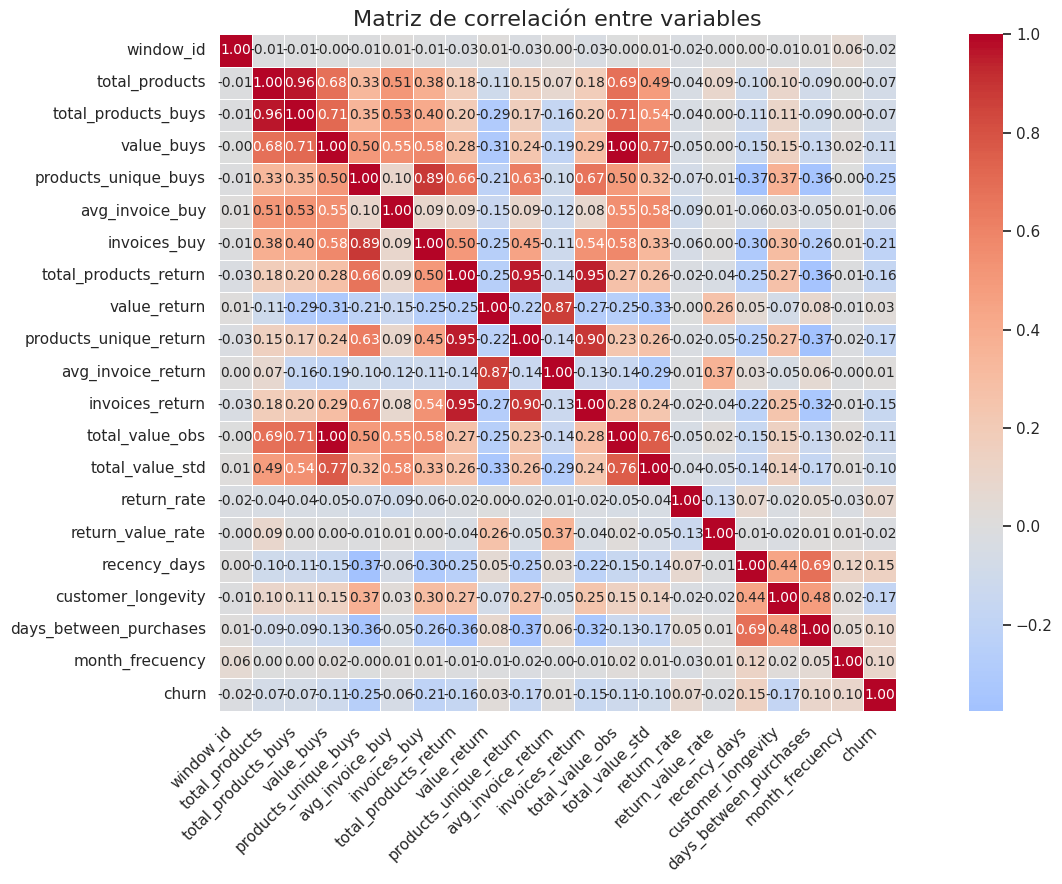

In [26]:
# Si estás usando tu DataFrame final con todas las features + churn
# Filtramos solo las columnas numéricas
df_corr = df_ventanas.select_dtypes(include='number')

# Calculamos la matriz de correlación
corr_matrix = df_corr.corr()

# Plot
plt.figure(figsize=(15, 9))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True, linewidths=0.5, annot_kws={"size": 10})

plt.title("Matriz de correlación entre variables", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

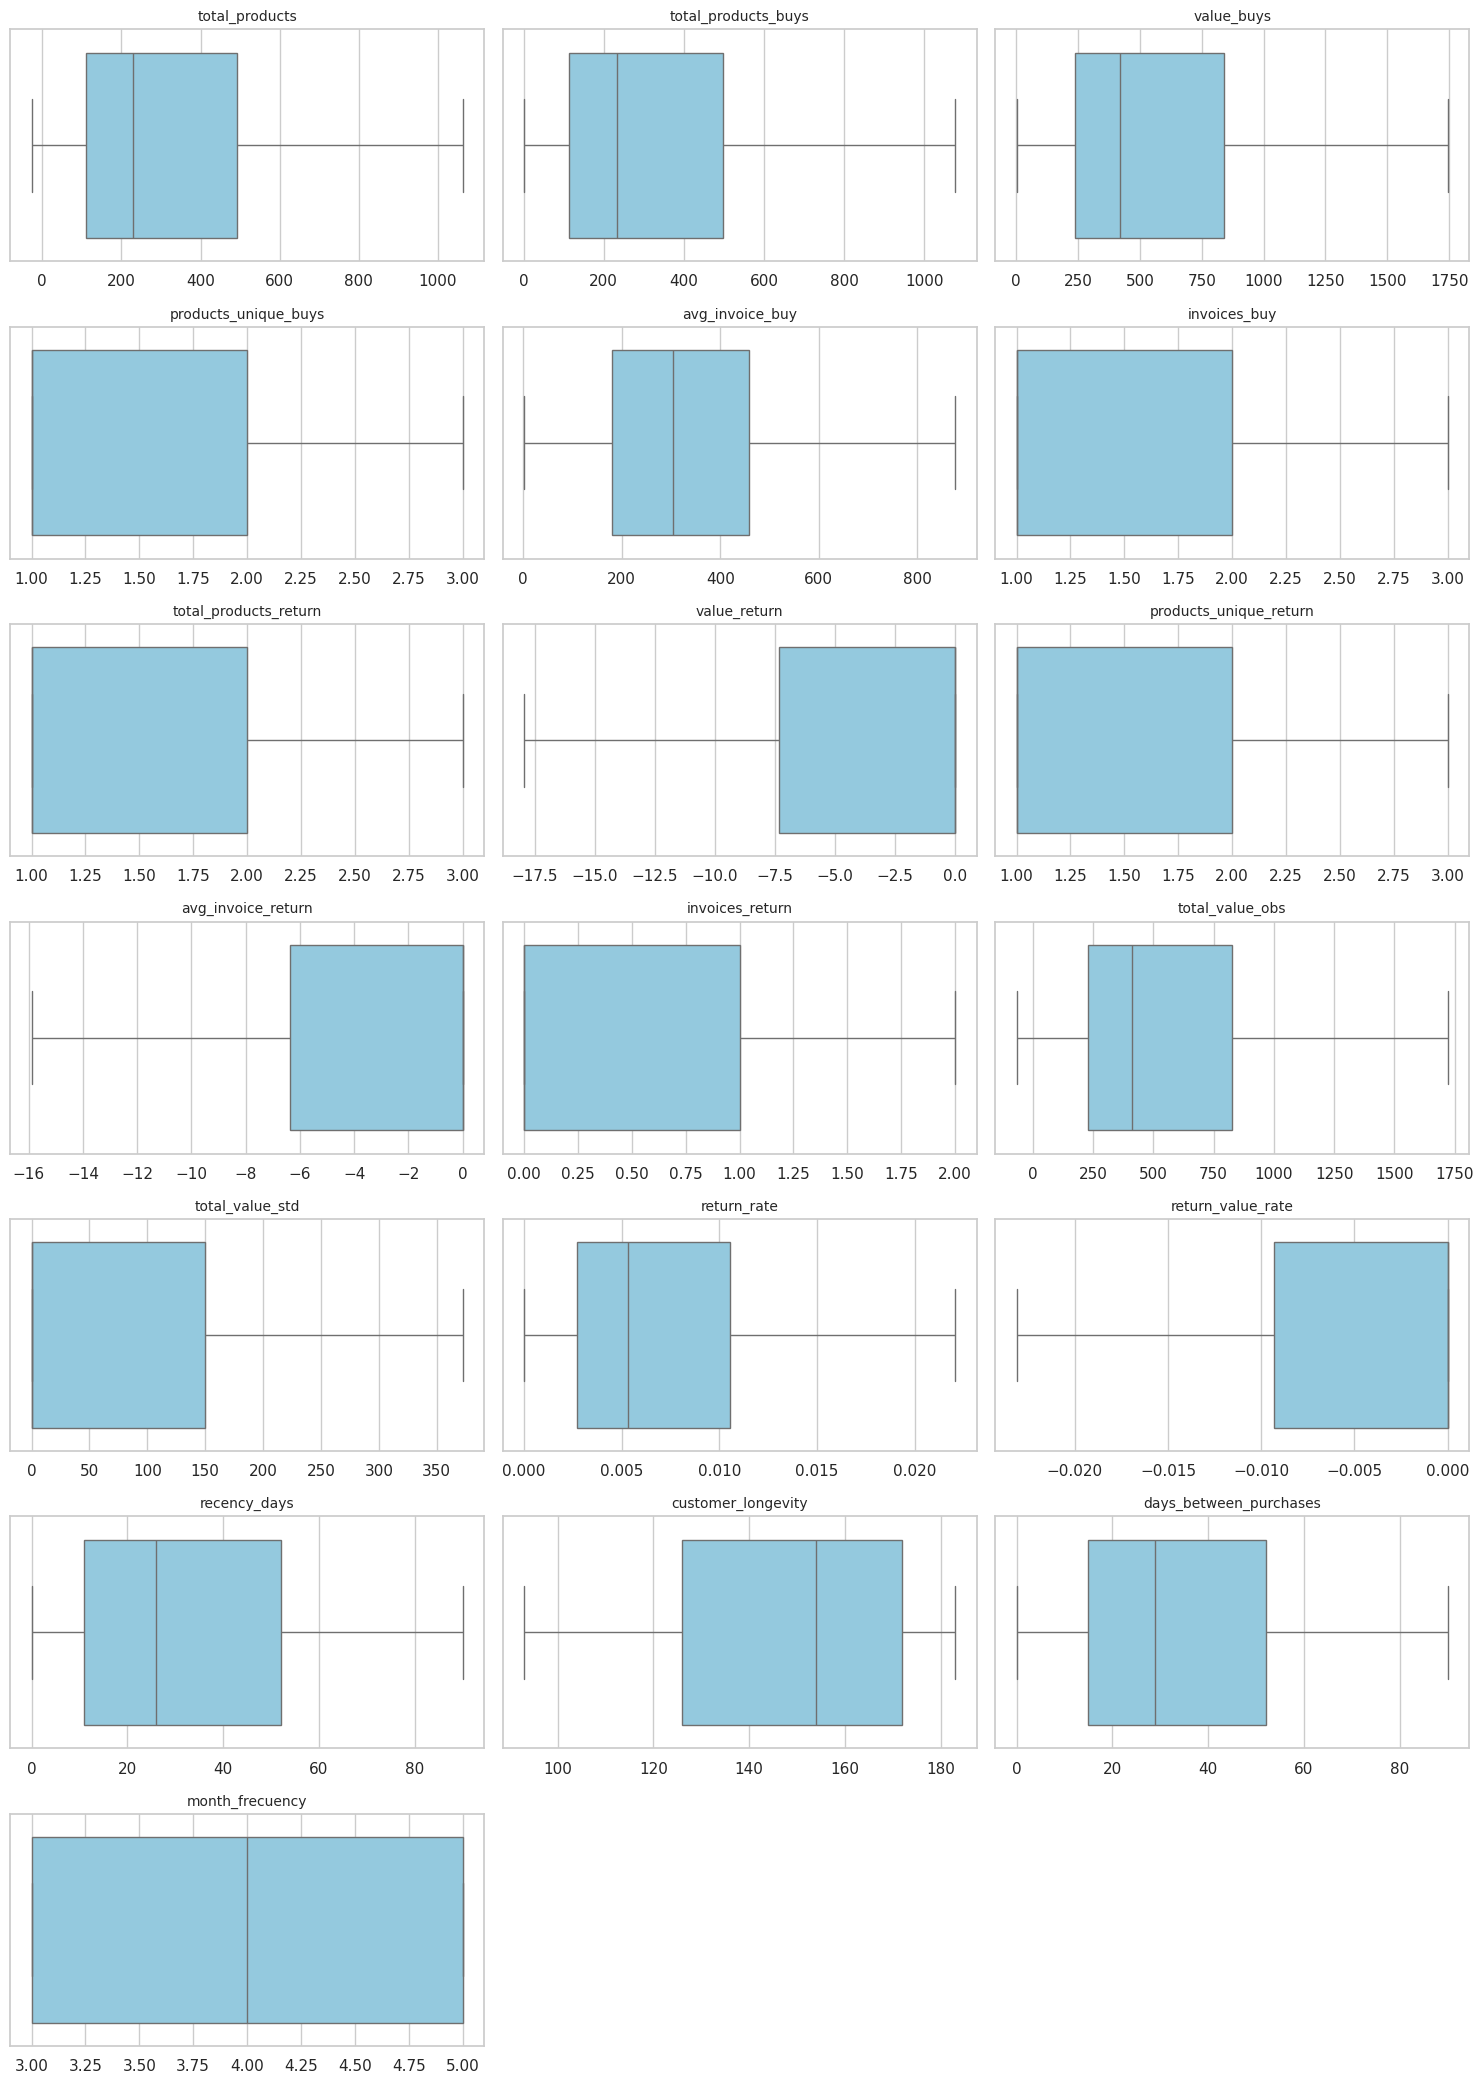

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Estilo bonito
sns.set(style="whitegrid")

# Variables numéricas sin columnas que no quieras graficar
variables_numericas = df_ventanas_f.select_dtypes(include='number').drop(columns=['CustomerID', 'window_id', 'churn'], errors='ignore')

# Número de columnas y filas del grid
n_cols = 3
n_vars = len(variables_numericas.columns)
n_rows = math.ceil(n_vars / n_cols)

# Tamaño ajustado de figura
plt.figure(figsize=(n_cols * 5, n_rows * 3))

# Crear boxplots en múltiples columnas
for i, col in enumerate(variables_numericas.columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=df_ventanas_f[df_ventanas_f['window_id'] == 2], x=col, color='skyblue')
    plt.title(f'{col}', fontsize=10)
    plt.xlabel('')
    plt.tight_layout()

plt.show()

In [11]:
def detectar_outliers_por_ventana(df, columnas, ventana_col='window_id'):
    resumen_total = []

    for ventana, df_v in df.groupby(ventana_col):
        outliers_dict = {}

        for col in columnas:
            Q1 = df_v[col].quantile(0.25)
            Q3 = df_v[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers = df_v[(df_v[col] < lower_bound) | (df_v[col] > upper_bound)]

            outliers_dict[col] = {
                'ventana': ventana,
                'cantidad_outliers': outliers.shape[0],
                'porcentaje_outliers': round(outliers.shape[0] / df_v.shape[0] * 100, 2)
            }

        resumen_ventana = pd.DataFrame(outliers_dict).T
        resumen_ventana['ventana'] = ventana
        resumen_total.append(resumen_ventana)

    return pd.concat(resumen_total)

# Usar:
columnas_numericas = df_ventanas.select_dtypes(include='number').drop(columns=['CustomerID', 'window_id', 'churn'], errors='ignore').columns.tolist()
resumen_outliers = detectar_outliers_por_ventana(df_ventanas, columnas_numericas)

In [14]:
resumen_outliers[resumen_outliers['porcentaje_outliers'] > 10].sort_index().head(3)

ventana  cantidad_outliers  porcentaje_outliers
avg_invoice_return        6              481.0                24.17
avg_invoice_return        5              373.0                22.23
avg_invoice_return        2              333.0                16.28

In [22]:
columnas_numericas = df_ftr.select_dtypes(include='number').drop(columns=['CustomerID', 'window_id', 'churn'], errors='ignore').columns.tolist()
resumen_outliers = detectar_outliers_por_ventana(df_ftr, columnas_numericas)
resumen_outliers

ventana  cantidad_outliers  porcentaje_outliers
total_products                1                1.0                 0.06
total_products_buys           1                0.0                 0.00
value_buys                    1                0.0                 0.00
products_unique_buys          1                0.0                 0.00
avg_invoice_buy               1                0.0                 0.00
...                         ...                ...                  ...
return_value_rate             7                1.0                 0.05
recency_days                  7                0.0                 0.00
customer_longevity            7                0.0                 0.00
days_between_purchases        7                0.0                 0.00
month_frecuency               7                0.0                 0.00

[133 rows x 3 columns]

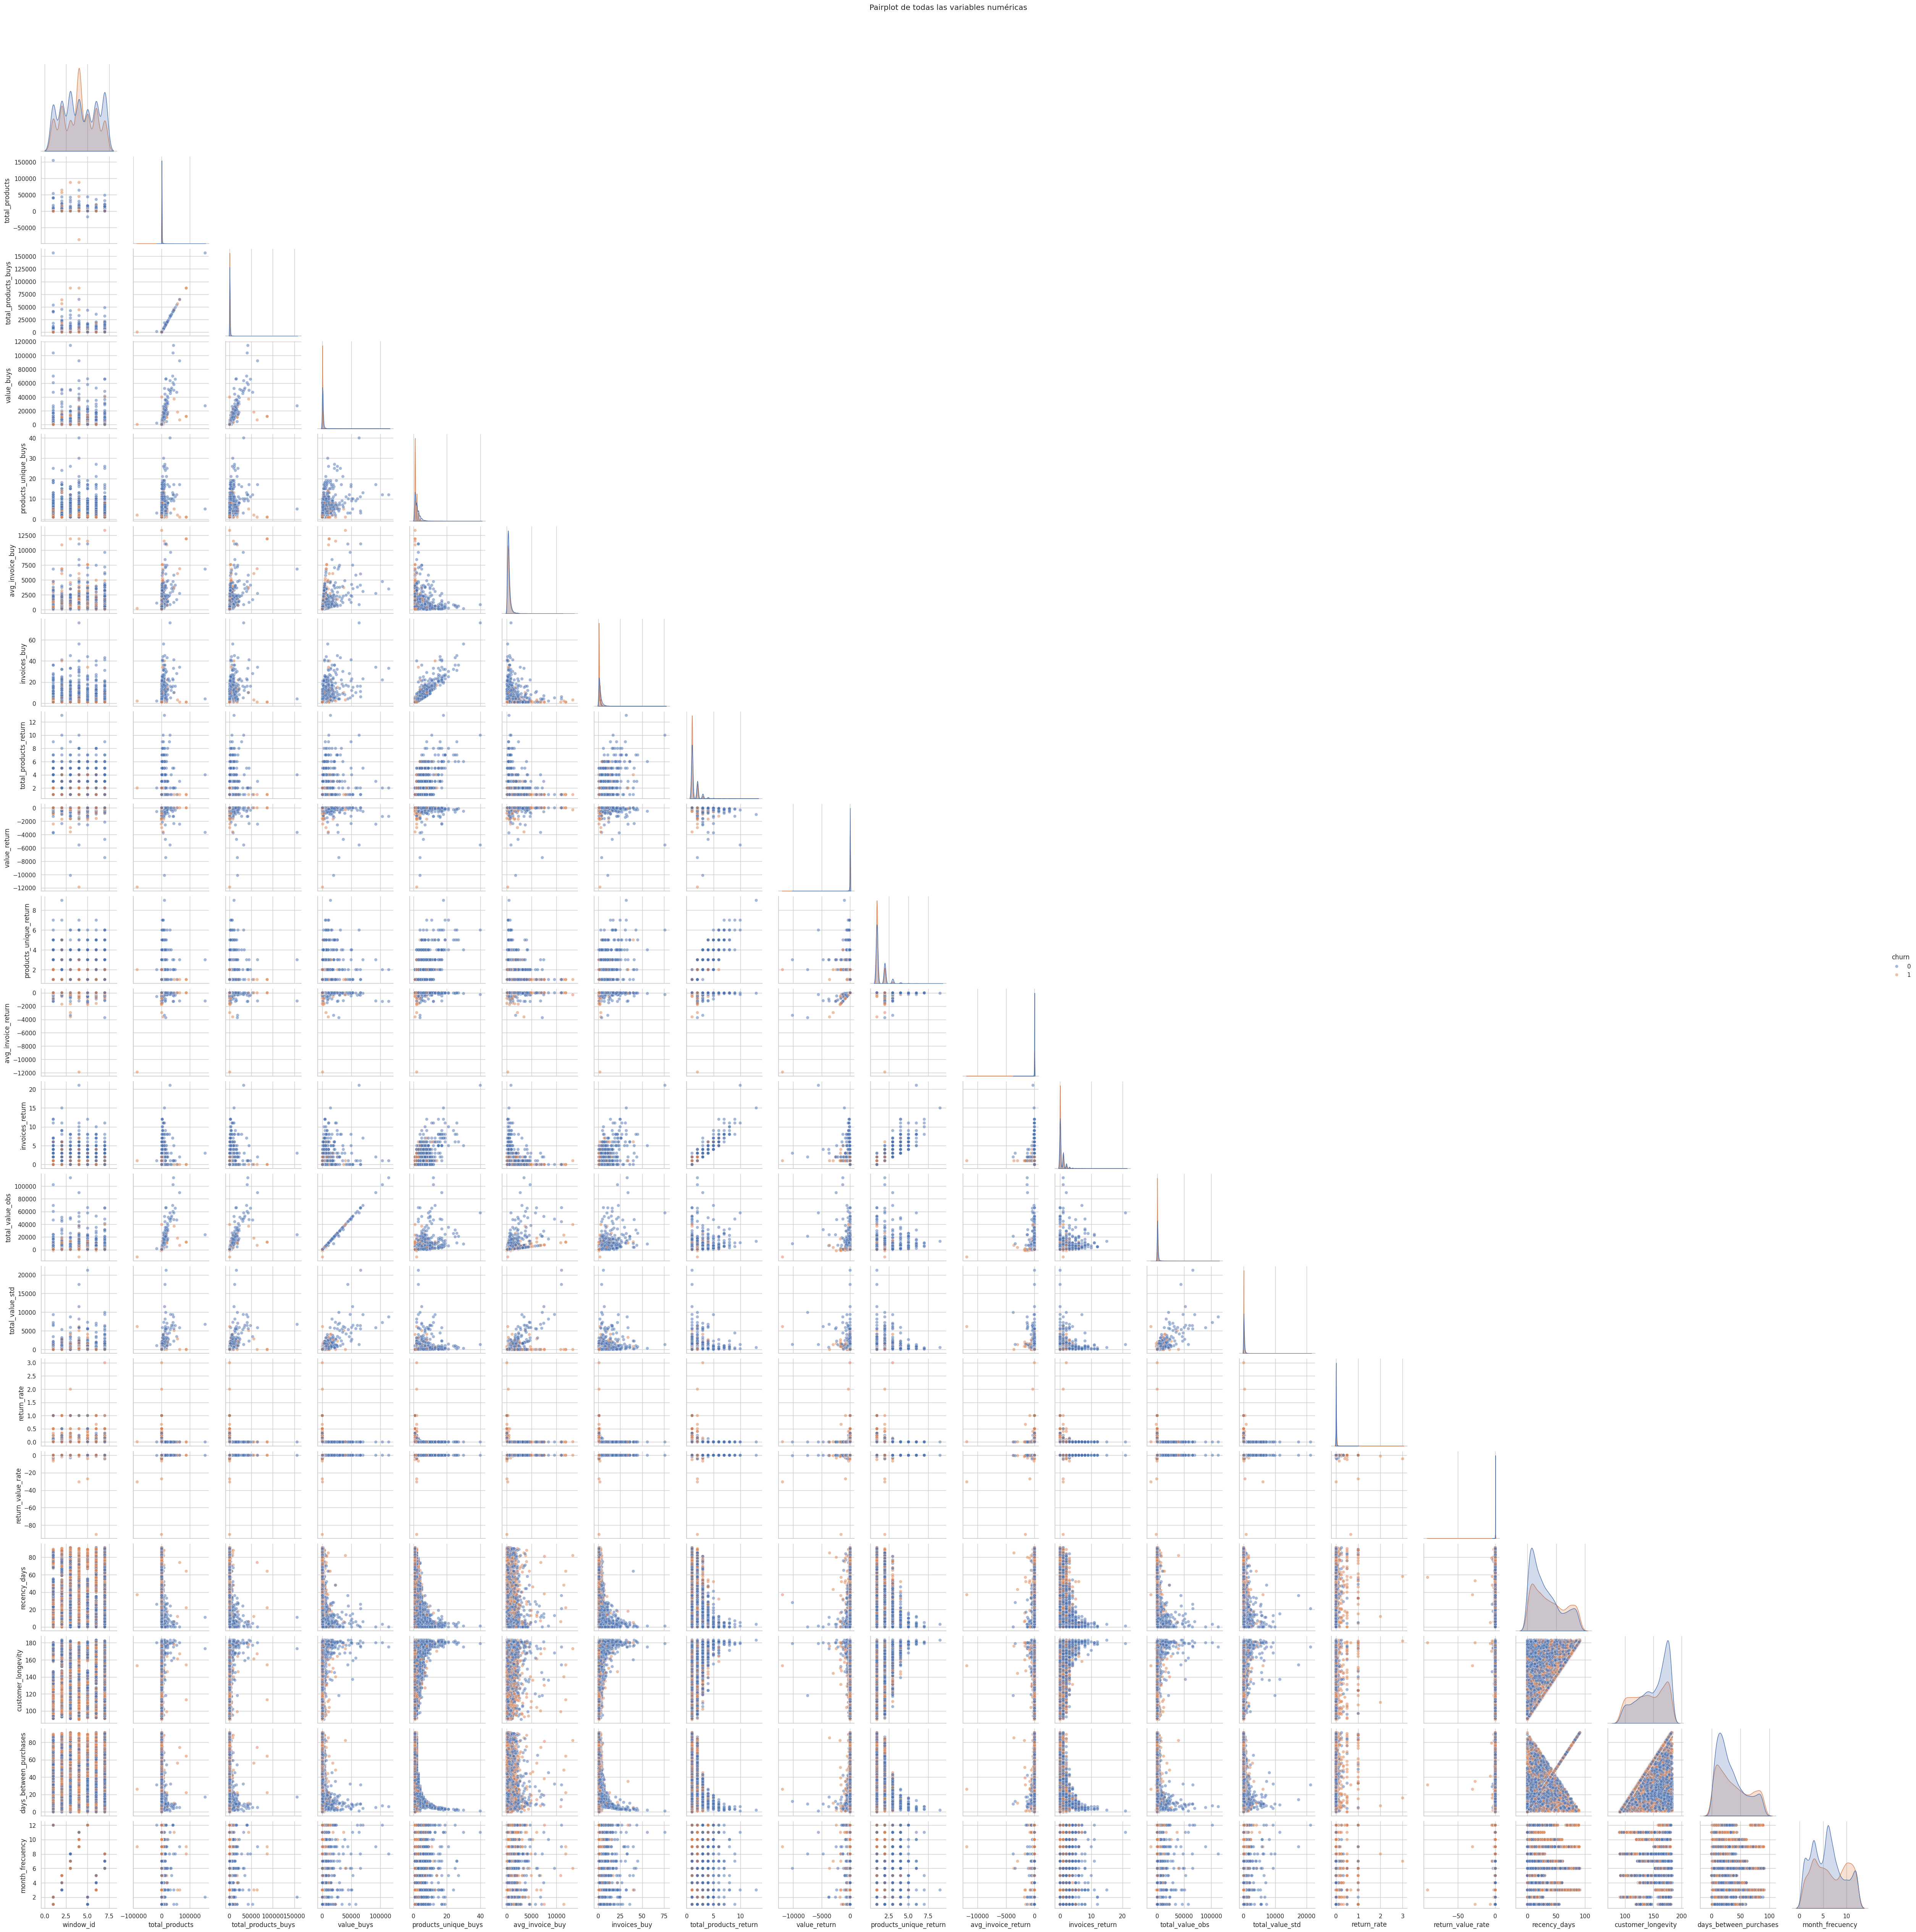

In [18]:
# Seleccionar solo columnas numéricas (incluyendo churn)
df_numericas = df_ventanas.select_dtypes(include='number')

# Asegúrate que 'churn' esté como entero
df_numericas['churn'] = df_numericas['churn'].astype(int)

# Plot
sns.pairplot(df_numericas, hue='churn', corner=True, diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot de todas las variables numéricas", y=1.02)
plt.show()

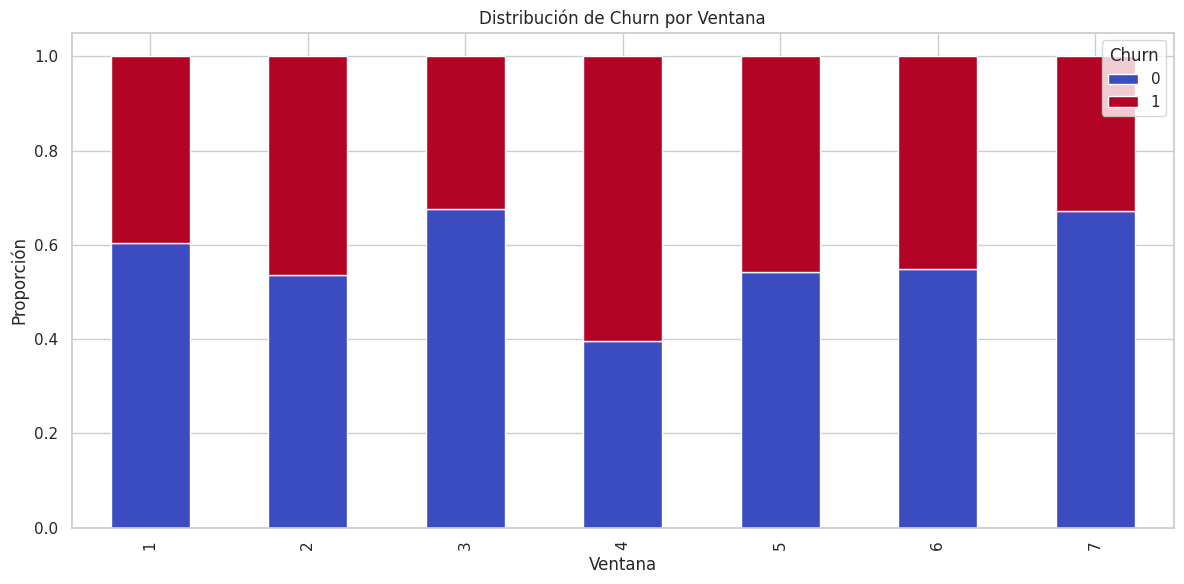

In [30]:
# Suponiendo que tienes 'window_id' y 'churn'
churn_dist = df_ventanas.groupby('window_id')['churn'].value_counts(normalize=True).unstack()

# Plot
churn_dist.plot(kind='bar', stacked=True, figsize=(12,6), colormap='coolwarm')
plt.title('Distribución de Churn por Ventana')
plt.ylabel('Proporción')
plt.xlabel('Ventana')
plt.legend(title='Churn')
plt.tight_layout()
plt.show()

In [14]:
churn_dist

churn             0         1
window_id                    
1          0.603165  0.396835
2          0.536919  0.463081
3          0.675026  0.324974
4          0.395688  0.604312
5          0.542908  0.457092
6          0.549246  0.450754
7          0.671988  0.328012

In [ ]:
# Seleccionar columnas numéricas (excluyendo 'ventana_id' si no es feature)
# df_hist = df_ventanas[df_ventanas['ventana_id'] == 1].copy()
df_hist = df_ventanas.copy()
df_hist = df_hist.select_dtypes(include='number').drop(columns=['ventana_id'], errors='ignore')

# Crear subplots
num_cols = df_hist.shape[1]
num_rows = (num_cols + 2) // 3  # 3 columnas por fila

plt.figure(figsize=(15, num_rows * 4))

for i, col in enumerate(df_hist.columns, 1):
    plt.subplot(num_rows, 3, i)
    plt.hist(df_hist[col].dropna(), bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Distribución de {col}')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
df_ventanas.info()

In [87]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

df_ventanas = pd.get_dummies(df_ventanas, columns=['month_frecuency'], prefix='mes', dtype=int)

df_train = df_ventanas[df_ventanas['window_id'] == 1].copy()
df_val   = df_ventanas[df_ventanas['window_id'] == 2].copy()
df_test  = df_ventanas[df_ventanas['window_id'] == 3].copy()

features = df_ventanas.drop(columns=['CustomerID', 'window_id', 'churn'], errors='ignore').select_dtypes(include='number').columns.tolist()
target = 'churn'

X_train, y_train = df_train[features], df_train[target]
X_val, y_val     = df_val[features], df_val[target]

In [88]:
ratio = (y_train == 0).sum() / (y_train == 1).sum()

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=ratio,
    random_state=42
)

# Entrenar
model.fit(X_train, y_train)

# Evaluar en validación
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]

print("Classification Report:")
print(classification_report(y_val, y_pred))

print("ROC AUC Score:", roc_auc_score(y_val, y_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.69      0.67      1188
           1       0.56      0.52      0.54       896

    accuracy                           0.62      2084
   macro avg       0.61      0.60      0.61      2084
weighted avg       0.61      0.62      0.61      2084

ROC AUC Score: 0.6831789810305436


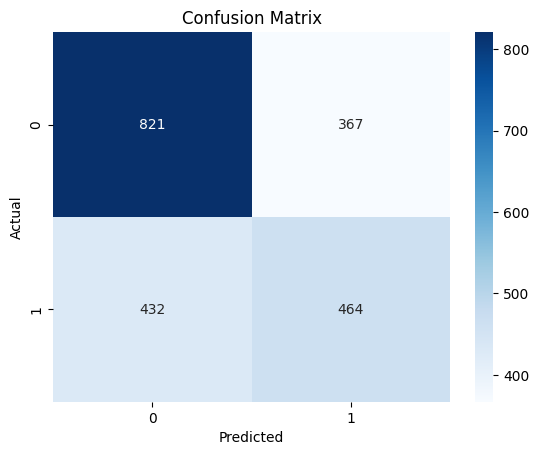

In [89]:
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [90]:
# Lista de modelos con diferentes parámetros
param_list = [
    {'max_depth': 3, 'learning_rate': 0.1},
    {'max_depth': 5, 'learning_rate': 0.1},
    {'max_depth': 3, 'learning_rate': 0.3},
    {'max_depth': 5, 'learning_rate': 0.3},
]

mejores_params = None
mejor_auc = 0

for params in param_list:
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        **params
    )
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_proba)
    print(f"Params {params} - AUC: {auc:.4f}")

    if auc > mejor_auc:
        mejor_auc = auc
        mejores_params = params

Params {'max_depth': 3, 'learning_rate': 0.1} - AUC: 0.7228
Params {'max_depth': 5, 'learning_rate': 0.1} - AUC: 0.7045
Params {'max_depth': 3, 'learning_rate': 0.3} - AUC: 0.6924
Params {'max_depth': 5, 'learning_rate': 0.3} - AUC: 0.6892


In [91]:
# Entrenar con mejores parámetros
final_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    **mejores_params
)
X_trainval = pd.concat([df_train, df_val])[features]
y_trainval = pd.concat([df_train, df_val])[target]

final_model.fit(X_trainval, y_trainval)

# Test
X_test = df_test[features]
y_test = df_test[target]
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

print("Reporte en Test:")
print(classification_report(y_test, y_pred))
print("ROC AUC Test:", roc_auc_score(y_test, y_proba))

Reporte en Test:
              precision    recall  f1-score   support

           0       0.79      0.70      0.74      1395
           1       0.45      0.56      0.50       599

    accuracy                           0.66      1994
   macro avg       0.62      0.63      0.62      1994
weighted avg       0.68      0.66      0.67      1994

ROC AUC Test: 0.6989450757235776


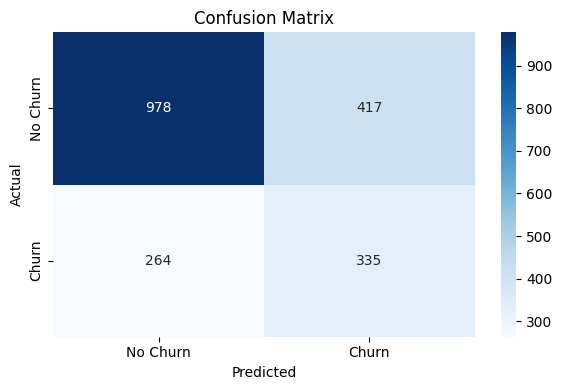

In [92]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [33]:
# XGBOOST CON GRIDSEARCH

df_ventanas = pd.get_dummies(df_ventanas, columns=['month_frecuency'], prefix='mes', dtype=int)

df_trainval = (
    df_ventanas
    .loc[df_ventanas['window_id'].between(1, 6)]
    .sort_values(['window_id'])   # ① orden temporal
    .reset_index(drop=True)
)

features = (
    df_trainval
    .drop(columns=['CustomerID', 'window_id', 'churn'], errors='ignore')
    .select_dtypes(include='number')
    .columns
    .tolist()
)

target = 'churn'

X = df_trainval[features]
y = df_trainval['churn']

In [34]:
from collections import Counter
# Calcular scale_pos_weight
# -----------------------------------------
counter = Counter(y)
neg, pos = counter[0], counter[1]
scale_pos_weight = neg / pos
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

scale_pos_weight: 1.16


In [35]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBClassifier

tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, scale_pos_weight, scale_pos_weight * 1.5],
}

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=tscv,
    n_jobs=-1,
    verbose=2
)

grid.fit(X, y)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1.163751987281399, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1, subs

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamm...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 200],
                         'scale_pos_weight': [1, 1.163751987281399,
                                              1.7456279809220985],
                         'subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=2)

In [36]:
print("Mejores hiperparámetros:")
print(grid.best_params_)
print("Mejor AUC en validación cruzada:")
print(grid.best_score_)

Mejores hiperparámetros:
{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1.7456279809220985, 'subsample': 0.8}
Mejor AUC en validación cruzada:
0.6951993213117267


In [37]:
mejores_params = grid.best_params_

final_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    **mejores_params
)

# Entrenar con train+val (por ejemplo usando ventanas 1–6)
final_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [38]:
df_test = df_ventanas[df_ventanas['window_id'] == 7].copy()
X_test = df_test[features]
y_test = df_test[target]

In [39]:
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]  # Para ROC AUC

In [40]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC Score
auc = roc_auc_score(y_test, y_proba)
print("\nROC AUC Score:", auc)


Matriz de Confusión:
[[617 688]
 [115 522]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.47      0.61      1305
           1       0.43      0.82      0.57       637

    accuracy                           0.59      1942
   macro avg       0.64      0.65      0.59      1942
weighted avg       0.71      0.59      0.59      1942


ROC AUC Score: 0.7005876444300089


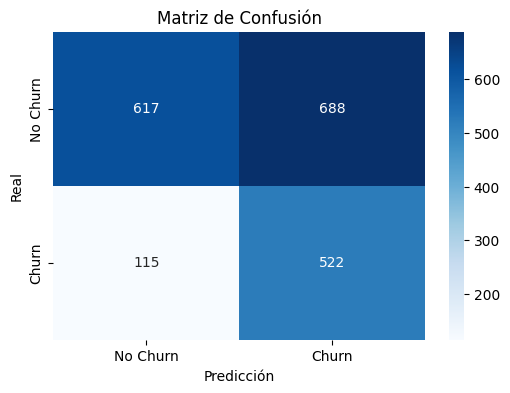

In [41]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

In [42]:
importances = pd.Series(final_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10)

invoices_buy              0.203205
products_unique_buys      0.148123
days_between_purchases    0.139043
total_value_obs           0.048720
value_buys                0.046585
total_products            0.042439
total_products_buys       0.038236
mes_10                    0.034691
mes_6                     0.034308
mes_9                     0.034255
dtype: float32

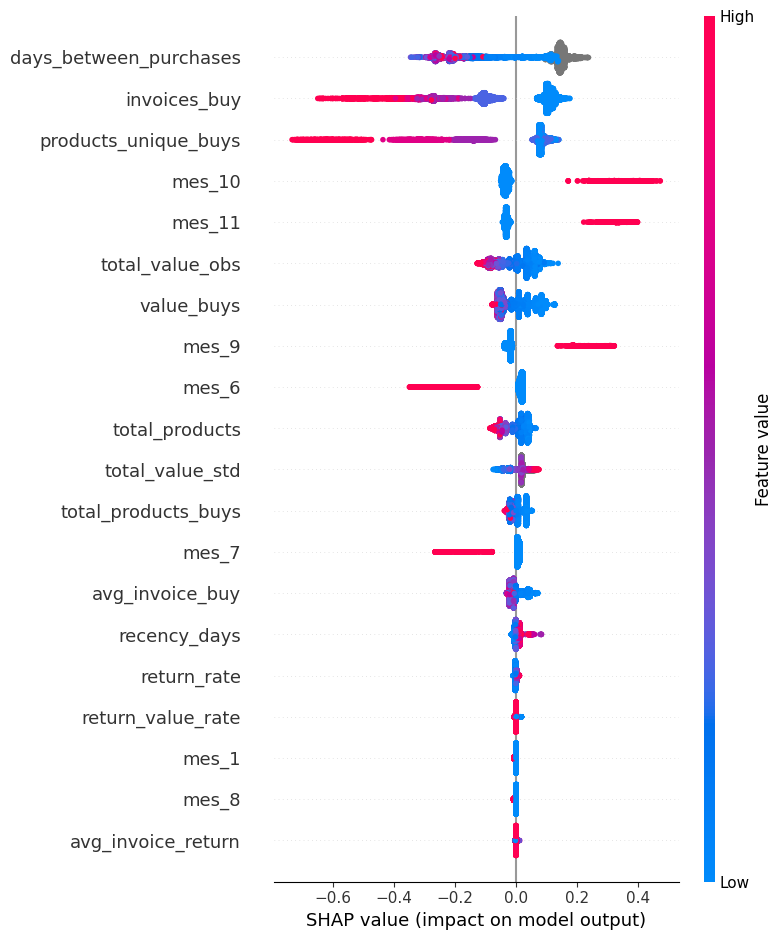

In [43]:
import shap

explainer = shap.Explainer(final_model)
shap_values = explainer(X)

shap.summary_plot(shap_values, X)

In [64]:
##MODEL
from sklearn.model_selection import ParameterGrid
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer

search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 15, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),  # ~0.05 to 1
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 42
}

In [10]:
def objective(params):
    model = XGBClassifier(
        n_estimators=100,
        random_state=42,
        **params
    )
    
    logo = LeaveOneGroupOut()
    
    scores = []
    for train_idx, val_idx in logo.split(X, y, groups=groups):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    avg_auc = np.mean(scores)
    return {'loss': -avg_auc, 'status': STATUS_OK}

In [21]:
df_ventanas = pd.get_dummies(df_ventanas, columns=['month_frecuency'], prefix='mes', dtype=int).sort_values(['window_id']).reset_index(drop=True)

df_trainval = df_ventanas[df_ventanas['window_id'] < 6]
df_test = df_ventanas[df_ventanas['window_id'] == 7]

groups = df_trainval['window_id']
y = df_trainval['churn']
X = df_trainval.drop(columns=['churn', 'window_id', 'CustomerID'])

In [ ]:
trials = Trials()
best = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=200,  # puedes subirlo si tu PC tiene buen hardware
    trials=trials,
    rstate=np.random.default_rng(42)
)

100%|██████████| 50/50 [01:53<00:00,  2.28s/trial, best loss: -0.6921059217776997]


In [23]:
# Convertimos los valores si es necesario
best_params = best.copy()
best_params['max_depth'] = int(best_params['max_depth'])

model_final = XGBClassifier(
    n_estimators=100,
    objective='binary:logistic',
    # eval_metric='auc',
    random_state=42,
    **best_params
)

# Entrenamos con TODO el dataset
model_final.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.644558075757783), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None,
              learning_rate=np.float64(0.050048414362908585), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=np.float64(9.332369117013155), missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predicciones (probabilidad y clase)
y_pred_proba = model_final.predict_proba(X)[:, 1]
y_pred = (y_pred_proba >= 0.3).astype(int)

# Matriz de confusión
print("Matriz de confusión:")
print(confusion_matrix(y, y_pred))

# Reporte de métricas
print("\nReporte de clasificación:")
print(classification_report(y, y_pred, digits=4))

# AUC
print("AUC:", roc_auc_score(y, y_pred_proba))

Matriz de confusión:
[[1981 3514]
 [ 380 4384]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8391    0.3605    0.5043      5495
           1     0.5551    0.9202    0.6925      4764

    accuracy                         0.6204     10259
   macro avg     0.6971    0.6404    0.5984     10259
weighted avg     0.7072    0.6204    0.5917     10259

AUC: 0.7489903041387904


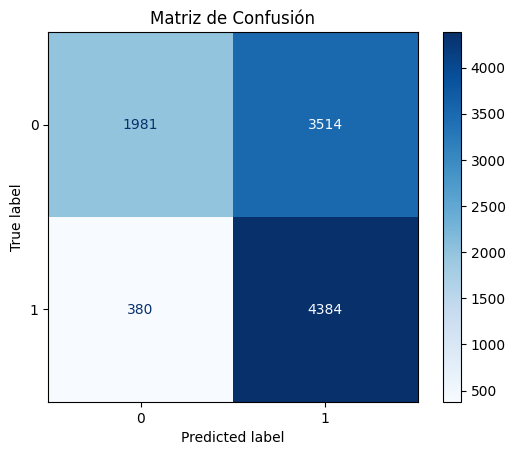

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap="Blues")
plt.title("Matriz de Confusión")
plt.grid(False)
plt.show()

In [31]:
X_test = df_test.drop(columns=['churn', 'window_id', 'CustomerID'])
y_test = df_test['churn']

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predicción sobre test
y_test_proba = model_final.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= 0.4).astype(int)

# Matriz de confusión
print("\n📊 Matriz de confusión (Test):")
print(confusion_matrix(y_test, y_test_pred))

# Reporte de métricas
print("\n📈 Reporte de clasificación (Test):")
print(classification_report(y_test, y_test_pred, digits=4))

# AUC
print("\n🔥 AUC (Test):", roc_auc_score(y_test, y_test_proba))


📊 Matriz de confusión (Test):
[[865 440]
 [234 403]]

📈 Reporte de clasificación (Test):
              precision    recall  f1-score   support

           0     0.7871    0.6628    0.7196      1305
           1     0.4781    0.6327    0.5446       637

    accuracy                         0.6529      1942
   macro avg     0.6326    0.6477    0.6321      1942
weighted avg     0.6857    0.6529    0.6622      1942


🔥 AUC (Test): 0.7065729563266508


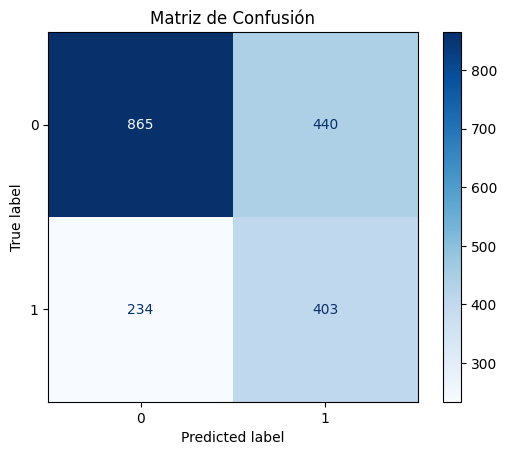

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, cmap="Blues")
plt.title("Matriz de Confusión")
plt.grid(False)
plt.show()

In [ ]:
##MODEL
from sklearn.model_selection import ParameterGrid
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer, classification_report, confusion_matrix, roc_auc_score

search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 15, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),  # ~0.05 to 1
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 42
}

def objective(params):
    model = XGBClassifier(
        n_estimators=100,
        random_state=42,
        **params
    )
    
    logo = LeaveOneGroupOut()
    
    scores = []
    for train_idx, val_idx in logo.split(X, y, groups=groups):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    avg_auc = np.mean(scores)
    return {'loss': -avg_auc, 'status': STATUS_OK}


In [ ]:
df_ventanas = pd.get_dummies(df_ventanas, columns=['month_frecuency'], prefix='mes', dtype=int).sort_values(['window_id']).reset_index(drop=True)

df_trainval = df_ventanas[df_ventanas['window_id'] < 6]
df_test = df_ventanas[df_ventanas['window_id'] == 7]

groups = df_trainval['window_id']
y = df_trainval['churn']
X = df_trainval.drop(columns=['churn', 'window_id', 'CustomerID'])

In [ ]:
# Convertimos los valores si es necesario
best_params = best.copy()
best_params['max_depth'] = int(best_params['max_depth'])

model_final = XGBClassifier(
    n_estimators=100,
    objective='binary:logistic',
    # eval_metric='auc',
    random_state=42,
    **best_params
)

# Entrenamos con TODO el dataset
model_final.fit(X, y)

# Predicciones (probabilidad y clase)
y_pred_proba = model_final.predict_proba(X)[:, 1]
y_pred = (y_pred_proba >= 0.3).astype(int)

# Matriz de confusión
print("Matriz de confusión:")
print(confusion_matrix(y, y_pred))

# Reporte de métricas
print("\nReporte de clasificación:")
print(classification_report(y, y_pred, digits=4))

# AUC
print("AUC:", roc_auc_score(y, y_pred_proba))

In [31]:
###### ELIGIENDO EL MODELO
df_ventanas_f = pd.get_dummies(df_ventanas_f, columns=['month_frecuency'], prefix='mes', dtype=int).sort_values(['window_id']).reset_index(drop=True)

train_df = df_ventanas_f[df_ventanas_f['window_id'] < 7]
test_df  = df_ventanas_f[df_ventanas_f['window_id'] == 7]

X_train = train_df.drop(columns=['CustomerID', 'window_id', 'churn'])
y_train = train_df['churn']

X_test = test_df.drop(columns=['CustomerID', 'window_id', 'churn'])
y_test = test_df['churn']

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Entrenando LogisticRegression...


/home/leonel-unix/workspace/mlops_dtc_project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Entrenando RandomForest...

Entrenando XGBoost...

Entrenando LightGBM...


/home/leonel-unix/workspace/mlops_dtc_project/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:19:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 5661, number of negative: 6588
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2688
[LightGBM] [Info] Number of data points in the train set: 12249, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.462160 -> initscore=-0.151649
[LightGBM] [Info] Start training from score -0.151649

Resultados comparativos:
                    Accuracy  Precision    Recall        F1   ROC AUC
LightGBM            0.680742   0.522193  0.313972  0.392157  0.690468
LogisticRegression  0.677137   0.551020  0.084772  0.146939  0.685844
RandomForest        0.653450   0.464000  0.364207  0.408091  0.670382
XGBoost             0.669928   0.495261  0.328100  0.394712  0.668187

Mejor modelo: LightGBM


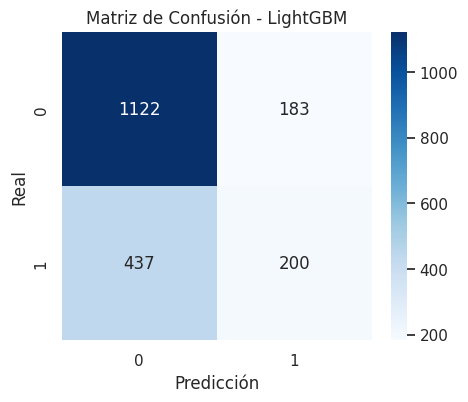

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Diccionario de modelos (con mínimos ajustes para evitar warnings)
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nEntrenando {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba)
    }

# Mostrar resultados ordenados por ROC AUC
results_df = pd.DataFrame(results).T.sort_values(by="ROC AUC", ascending=False)
print("\nResultados comparativos:")
print(results_df)

# Mostrar matriz de confusión del mejor modelo
best_model_name = results_df.index[0]
best_model = models[best_model_name]
print(f"\nMejor modelo: {best_model_name}")

y_pred_best = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de Confusión - {best_model_name}")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

In [35]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope
from sklearn.preprocessing import StandardScaler


# Asegurarte de separar correctamente
train_val_df = df_ventanas_f[df_ventanas_f["window_id"] < 7].copy()  # ventanas 1 a 6
test_df = df_ventanas_f[df_ventanas_f["window_id"] == 7].copy()      # ventana 7

# Features
features = train_val_df.drop(columns=["CustomerID", "window_id", "churn"]).columns
X_train_val = train_val_df[features]
y_train_val = train_val_df["churn"]
window_ids_train = sorted(train_val_df["window_id"].unique())

X_train_val[features] = X_train_val[features].astype(float)
X_test[features] = X_test[features].astype(float)


X_test = test_df[features]
y_test = test_df["churn"]

# Escalado
scaler = StandardScaler()
X_train_val[features] = scaler.fit_transform(X_train_val[features])
X_test[features] = scaler.transform(X_test[features])

/tmp/ipykernel_1065/2062737835.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val[features] = X_train_val[features].astype(float)
/tmp/ipykernel_1065/2062737835.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val[features] = scaler.fit_transform(X_train_val[features])
/tmp/ipykernel_1065/2062737835.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [37]:
def rolling_origin_cv(params):
    aucs = []
    for i in range(2, 6):  # ventanas 1→i para train, i+1 para valid
        train_windows = list(range(1, i + 1))
        val_window = i + 1

        train_idx = train_val_df[train_val_df["window_id"].isin(train_windows)].index
        val_idx = train_val_df[train_val_df["window_id"] == val_window].index

        X_train = X_train_val.loc[train_idx]
        y_train = y_train_val.loc[train_idx]
        X_val = X_train_val.loc[val_idx]
        y_val = y_train_val.loc[val_idx]

        model = LGBMClassifier(
            max_depth=int(params["max_depth"]),
            learning_rate=params["learning_rate"],
            reg_alpha=params["reg_alpha"],
            reg_lambda=params["reg_lambda"],
            min_child_weight=params["min_child_weight"],
            subsample=params["subsample"],
            colsample_bytree=params["colsample_bytree"],
            n_estimators=100,
            objective='binary',
            random_state=42,
            verbosity=-1
        )
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    return -np.mean(aucs)  # Hyperopt minimiza

# 🎯 Espacio de hiperparámetros
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 15, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),         # ~0.05–1.0
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)
}

# 🔁 Optimización con Hyperopt
trials = Trials()
best = fmin(
    fn=lambda params: {'loss': rolling_origin_cv(params), 'status': STATUS_OK},
    space=search_space,
    algo=tpe.suggest,
    max_evals=200,
    trials=trials,
    rstate=np.random.default_rng(42)
)

print("✅ Mejores hiperparámetros encontrados:")
print(best)

100%|██████████| 200/200 [00:44<00:00,  4.53trial/s, best loss: -0.6911886881966405]
✅ Mejores hiperparámetros encontrados:
{'colsample_bytree': np.float64(0.7137041694081874), 'learning_rate': np.float64(0.05021046639779424), 'max_depth': np.float64(4.0), 'min_child_weight': np.float64(2.744989347523962), 'reg_alpha': np.float64(0.014471193813037903), 'reg_lambda': np.float64(0.009400474935832476), 'subsample': np.float64(0.8085202651782474)}


In [1]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
)
import matplotlib.pyplot as plt

best["max_depth"] = int(best["max_depth"])

# 1. Crear y entrenar modelo con mejores hiperparámetros
model = LGBMClassifier(
    **best,
    n_estimators=100,
    objective='binary',
    random_state=42,
    verbosity=-1
)
model.fit(X_train_val, y_train_val)

# 2. Predicción sobre ventana 7
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.6).astype(int)

# 3. Métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print("🔍 Evaluación en Ventana 7:")
print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall   : {rec:.4f}")
print(f"✅ F1 Score : {f1:.4f}")
print(f"✅ AUC      : {auc:.4f}")

# 4. Matriz de Confusión
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap="Blues", values_format='d')
plt.title("📊 Matriz de Confusión - Ventana 7")
plt.show()

# 5. Curva Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('🎯 Curva Precision-Recall - Ventana 7')
plt.grid(True)
plt.show()

NameError: name 'best' is not defined